# Image Identification - Fire and Smoke in the Forest

In oil palm plantations, fire is one of disasters that must be resolved. We can prevent and cope with it by early fire detection. However, it is high-cost to have fire detection system. So we can develop a fire detection from drone images using deep learning.

We will identify forest fire and smoke images using dataset [Forest Fire](https://www.kaggle.com/datasets/kutaykutlu/forest-fire). What we are going to do are:
1. Data Pre-processing : prepare training and validation data with th same size.
2. Train Model : start training and validate the model.
3. Testing Model
4. Result and Recommendation

## Import Package

Import important package for this classification and check is GPU available in our laptop or not. If no, the process will be running slowly.

In [ ]:
!pip install tensorflow-gpu==2.9.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 2.3 MB/s eta 0:00:00


In [ ]:
!pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import cv2
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import shutil
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from IPython.core.display import display, HTML

In [2]:
!pip install tf-nightly 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.0/586.0 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.9/440.9 KB 45.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.8/409.8 KB 40.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 83.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 105.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 86.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 91.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 100.0 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorbo

In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
#Checking if i have GPU Enabled
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Preprocessing

1. Check sum of training dataset to know the data is balance or not. If it's imbalance, set the sum of images we will use to train.
2. All of the images do not have same size. So, we have to resize and rescale them. Resize is to make image in the same size, while rescale to change image value scale.

In [ ]:
# Define the root directory to start from
root_dir = '/content/drive/MyDrive/Bootcamp/Final Project/Training Data'

# Create an empty list to store the file paths and sub folder names
data = []

# Loop through the sub folders in the root directory
for subdir, dirs, files in os.walk(root_dir):
    for file in files:
        #Extract the sub folder name from the full path
        subfolder_name = os.path.basename(subdir)
        #Create a dictionary for each file with the subfolder name and filepath
        file_data = {
            'Class': subfolder_name,
            'Filepath': os.path.join(subdir, file)
        }
        # Append the file data to the list
        data.append(file_data)

# Create a data frame from the list
df = pd.DataFrame(data)
df

,Class,Filepath
0,Smoke,/content/drive/MyDrive/Bootcamp/Final Project/...
1,Smoke,/content/drive/MyDrive/Bootcamp/Final Project/...
2,Smoke,/content/drive/MyDrive/Bootcamp/Final Project/...
3,Smoke,/content/drive/MyDrive/Bootcamp/Final Project/...
4,Smoke,/content/drive/MyDrive/Bootcamp/Final Project/...
...,...,...
13728,Fire,/content/drive/MyDrive/Bootcamp/Final Project/...
13729,Fire,/content/drive/MyDrive/Bootcamp/Final Project/...
13730,Fire,/content/drive/MyDrive/Bootcamp/Final Project/...
13731,Fire,/content/drive/MyDrive/Bootcamp/Final Project/...


(1080, 1920, 3)


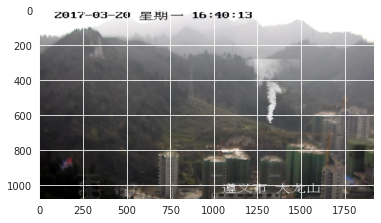

In [ ]:
img=plt.imread(df['Filepath'][1370])
print(img.shape)
imshow(img)

In [ ]:
classes=df['Class'].unique()
class_count=len(classes)

In [ ]:
df['Class'].value_counts()

Smoke    12631
Fire      1102
Name: Class, dtype: int64

In [ ]:
df['Class'].value_counts(normalize=True)*100

Smoke    91.975533
Fire      8.024467
Name: Class, dtype: float64

Because the dataset is highly imbalance, so we only do data augmentation on fire image dataset untill ratio of fire and smoke data 30 : 70 or 40 : 60. The augmentation are:
1. rotating the image by 20 degrees
2. flipping image horizontal and vertical
3. shift image for width and height 0.2
4. zoom the image 0.2

So, we will make it at least 5 times from original fire data or total 5510 fire images.

In [ ]:
# Create directories to hold the augmented images
working_dir=r'/content/drive/MyDrive/Bootcamp/Final Project'
aug_dir=os.path.join(working_dir, 'aug')
if os.path.isdir(aug_dir):
    shutil.rmtree(aug_dir)
os.mkdir(aug_dir)
for label in df['Class'].unique():
    dir_path=os.path.join(aug_dir,label)    
    os.mkdir(dir_path)
print(os.listdir(aug_dir))

In [ ]:
# Create augmented images and store in the aug directories
target=5510 # set the target count for each class in df
gen=ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=20, width_shift_range=.2,
                              height_shift_range=.2, zoom_range=.2)

groups=df.groupby('Class') # group by class
for label in df['Class'].unique():  # for every class               
    group=groups.get_group(label)  # a dataframe holding only rows with the specified label 
    sample_count=len(group)   # determine how many samples there are in this class  
    if sample_count< target: # if the class has less than target number of images
        aug_img_count=0
        delta=target-sample_count  # number of augmented images to create
        target_dir=os.path.join(aug_dir, label)  # define where to write the images    
        aug_gen=gen.flow_from_dataframe(group,  x_col='Filepath', y_col=None, target_size=(400,400), class_mode=None, batch_size=1,
                                         shuffle=False, save_to_dir=target_dir, save_prefix='aug-',save_format='jpg')
        while aug_img_count<delta:
            images=next(aug_gen)            
            aug_img_count += len(images)

In [ ]:
working_dir=r'./'
aug_dir=os.path.join(working_dir, 'aug')

In [ ]:
# Create aug_df for fire class
class_to_oversample = 'Fire'

aug_fpaths=[]
aug_labels=[]
classlist=os.listdir(aug_dir)
for klass in classlist:
    if klass == class_to_oversample:
        classpath = os.path.join(aug_dir, klass)     
        flist = os.listdir(classpath)    
        for f in flist:        
            fpath = os.path.join(classpath, f)         
            aug_fpaths.append(fpath)
            aug_labels.append(klass)
            
Fseries=pd.Series(aug_fpaths, name='Filepath')
Lseries=pd.Series(aug_labels, name='Class')
aug_df=pd.concat([Fseries, Lseries], axis=1)
print('length of aug_df ', len(aug_df))

# Concatenate with df
df_over=pd.concat([df,aug_df], axis=0).reset_index(drop=True)
print('length of df is: ', len(df_over)) 
print(df_over['Class'].value_counts())

In [ ]:
print (df_over['Class'].value_counts(normalize=True)*100)

After handling imbalance data, split into train, validation and test. Also create the generator.

In [ ]:
# Split train, validation, and test dataset
train_split=0.9
test_split=0.05

# First splitting: pretrain and test
pretrain_df, test_df=train_test_split(df_over, test_size=test_split, shuffle=True, random_state=123)

# Second splitting: train and validation
train_df, valid_df=train_test_split(pretrain_df, train_size=train_split, shuffle=True, random_state=123)

print ('train samples: ', len(train_df),'  test samples: ', len(test_df), ' validation samples', len(valid_df))

In [ ]:
def show_image_samples(gen, class_names):
    class_dict=gen.class_indices
    new_dict={}
    # make a new dictionary with keys and values reversed
    for key, value in class_dict.items(): # dictionary is now {numeric class label: string of class_name}
        new_dict[value]=key        
    images,labels=next(gen) # get a sample batch from the generator   
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=(images[i]+1 )/2 # scale images between 0 and 1 becaue pre-processor set them between -1 and +1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=class_names[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

In [ ]:
# Image target size
length=400
width=200
channel=3
img_size=(width, length)
img_shape=(width, length, channel)

# Batch is used to set how many images will we train in once 
batch_size=20

In [ ]:
# Set data augmentation in ImageDataGenerator
def scalar(img):
    return img/127.5-1  # scale pixel between -1 and +1

trgen = ImageDataGenerator(preprocessing_function=scalar,
                           rescale=1./255,
                           horizontal_flip=True,
                           vertical_flip=True,shear_range=0.2,
                           zoom_range=0.2, width_shift_range=0.2,
                           height_shift_range=0.2)

tvgen = ImageDataGenerator(preprocessing_function=scalar)

In [ ]:
train_gen = trgen.flow_from_dataframe(train_df, x_col='Filepath', y_col='Class', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', batch_size=batch_size)
valid_gen = tvgen.flow_from_dataframe(valid_df, x_col='Filepath', y_col='Class', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', batch_size=batch_size)
test_gen = tvgen.flow_from_dataframe(test_df, x_col='Filepath', y_col='Class', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', batch_size=batch_size)

In [ ]:
show_image_samples(test_gen, classes)

Create a custom Keras callback to continue or halt training

In [ ]:
class LR_ASK(tf.keras.callbacks.Callback):
    def __init__ (self, model, epochs,  ask_epoch, dwell=True, factor=.4): # initialization of the callback
        super(LR_ASK, self).__init__()
        self.model=model               
        self.ask_epoch=ask_epoch
        self.epochs=epochs
        self.ask=True # if True query the user on a specified epoch
        self.lowest_vloss=np.inf
        self.lowest_aloss=np.inf
        self.best_weights=self.model.get_weights() # set best weights to model's initial weights
        self.best_epoch=1
        self.plist=[]
        self.alist=[]
        self.dwell= dwell
        self.factor=factor
        
    def get_list(self): # define a function to return the list of % validation change
        return self.plist, self.alist
    def on_train_begin(self, logs=None): # this runs on the beginning of training
        if self.ask_epoch == 0: 
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch=1
        if self.ask_epoch >= self.epochs: # you are running for epochs but ask_epoch>epochs
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask=False # do not query the user
        if self.epochs == 1:
            self.ask=False # running only for 1 epoch so do not query user
        else:
            msg =f'Training will proceed until epoch {self.ask_epoch} then you will be asked to' 
            print(msg)
            msg='enter H to halt training or enter an integer for how many more epochs to run then be asked again'
            print(msg)
            if self.dwell:
                msg='learning rate will be automatically adjusted during training'
                print(msg)
        self.start_time= time.time() # set the time at which training started
       
    def on_train_end(self, logs=None):   # runs at the end of training  
        msg=f'loading model with weights from epoch {self.best_epoch}'
        print(msg)
        self.model.set_weights(self.best_weights) # set the weights of the model to the best weights
        tr_duration=time.time() - self.start_time   # determine how long the training cycle lasted         
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg) # print out training duration time
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        vloss=logs.get('val_loss')  # get the validation loss for this epoch
        aloss=logs.get('loss')
        if epoch >0:
            deltav = self.lowest_vloss- vloss 
            pimprov=(deltav/self.lowest_vloss) * 100 
            self.plist.append(pimprov)
            deltaa=self.lowest_aloss-aloss
            aimprov=(deltaa/self.lowest_aloss) * 100
            self.alist.append(aimprov)
        else:
            pimprov=0.0 
            aimprov=0.0
        if vloss< self.lowest_vloss:
            self.lowest_vloss=vloss
            self.best_weights=self.model.get_weights() # set best weights to model's initial weights
            self.best_epoch=epoch + 1            
            msg=f'\n validation loss of {vloss:7.4f} is {pimprov:7.4f} % below lowest loss, saving weights from epoch {str(epoch + 1):3s} as best weights'
            print(msg) # green foreground
        else: # validation loss increased
            pimprov=abs(pimprov)
            msg=f'\n validation loss of {vloss:7.4f} is {pimprov:7.4f} % above lowest loss of {self.lowest_vloss:7.4f} keeping weights from epoch {str(self.best_epoch)} as best weights'
            print(msg, (255,255,0)) # yellow foreground
            if self.dwell: # if dwell is True when the validation loss increases the learning rate is automatically reduced and model weights are set to best weights
                lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                new_lr=lr * self.factor
                msg=f'learning rate was automatically adjusted from {lr:8.6f} to {new_lr:8.6f}, model weights set to best weights'
                print(msg) # cyan foreground
                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                self.model.set_weights(self.best_weights) # set the weights of the model to the best weights      
                
        if aloss< self.lowest_aloss:
            self.lowest_aloss=aloss        
        if self.ask: # are the conditions right to query the user?
            if epoch + 1 ==self.ask_epoch: # is this epoch the one for quering the user?                
                msg='\n Enter H to end training or  an integer for the number of additional epochs to run then ask again'
                print(msg) # cyan foreground
                ans=input()
                
                if ans == 'H' or ans =='h' or ans == '0': # quit training for these conditions
                    msg=f'you entered {ans},  Training halted on epoch {epoch+1} due to user input\n'
                    print(msg)
                    self.model.stop_training = True # halt training
                else: # user wants to continue training
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush =True)
                    else:
                        msg=f'you entered {ans} Training will continue to epoch {self.ask_epoch}'
                        print(msg) # cyan foreground
                        if self.dwell==False:
                            lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                            msg=f'current LR is  {lr:8.6f}  hit enter to keep  this LR or enter a new LR'
                            print(msg) # cyan foreground
                            ans=input(' ')
                            if ans =='':
                                msg=f'keeping current LR of {lr:7.5f}'
                                print(msg) # cyan foreground
                            else:
                                new_lr=float(ans)
                                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                                msg=f' changing LR to {ans}'
                                print(msg) # cyan foreground

Create a function to calculate the F1 score metric

In [ ]:
from tensorflow.keras import backend as K

def F1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

Define a function to plot the training data

In [ ]:
def tr_plot(tr_data):
    start_epoch=0
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    tf1=tr_data.history['F1_score']
    vf1=tr_data.history['val_F1_score']    
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    indexf1=np.argmax(vf1)
    vf1_highest=vf1[indexf1]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch) 
    f1_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=3, figsize=(25,10))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].scatter(Epochs, tloss, s=100, c='red')    
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs', fontsize=18)
    axes[0].set_ylabel('Loss', fontsize=18)
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].scatter(Epochs, tacc, s=100, c='red')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs', fontsize=18)
    axes[1].set_ylabel('Accuracy', fontsize=18)
    axes[1].legend()
    axes[2].plot (Epochs,tf1,'r',label= 'Training F1 score')    
    axes[2].plot (Epochs,vf1,'g',label= 'Validation F1 score')
    index_tf1=np.argmax(tf1)#  this is the epoch with the highest training F1 score
    tf1max=tf1[index_tf1]
    index_vf1=np.argmax(vf1)# thisiis the epoch with the highest validation F1 score
    vf1max=vf1[index_vf1]
    axes[2].scatter(index_vf1+1 +start_epoch,vf1max, s=150, c= 'blue', label=vc_label)    
    axes[2].scatter(Epochs, tf1, s=100, c='red')
    axes[2].set_title('Training and Validation F1 score')
    axes[2].set_xlabel('Epochs', fontsize=18)
    axes[2].set_ylabel('F1  score', fontsize=18)
    axes[2].legend()    
    plt.tight_layout    
    plt.show()
    return 

In [ ]:
def print_info(test_gen, preds, print_code, save_dir, subject):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) +'.txt'  
    dict_path=os.path.join(save_dir,dict_name)    
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)    
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)        
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index)    
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):                
                split1=os.path.split(error_list[i])                
                split2=os.path.split(split1[0])                
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])               
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class 
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)        
    y_pred=np.array(y_pred)
    if len(classes)<= 30:
        # create a confusion matrix 
        cm = confusion_matrix(y_true, y_pred )        
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

## CNN Sequential Modeling

In image identification, CNN is commonly used because it often gets high accuracy values. In this case we will use Sequential with different number of layers and EfficientNet.

In [ ]:
# Initializing CNN Sequential
cnn_seq=tf.keras.models.Sequential()

# first layer
cnn_seq.add(tf.keras.layers.Conv2D(filters=32,kernel_size=7,padding='same',activation='relu',input_shape=img_shape))
cnn_seq.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# second layer
cnn_seq.add(tf.keras.layers.Conv2D(filters=64,kernel_size=3,padding='same',activation='relu'))
cnn_seq.add(tf.keras.layers.MaxPool2D(pool_size=2, strides= 2))

# thrid layer
cnn_seq.add(tf.keras.layers.Conv2D(filters=128,kernel_size=3,padding='same',activation='relu'))
cnn_seq.add(tf.keras.layers.MaxPool2D(pool_size=2, strides= 2))

# flattening layer
cnn_seq.add(tf.keras.layers.Flatten())

# fully connected layer
cnn_seq.add(tf.keras.layers.Dense(units=256,activation='relu'))
cnn_seq.add(tf.keras.layers.Dropout(0.5))

# output layers
cnn_seq.add(tf.keras.layers.Dense(units=2,activation='softmax'))

cnn_seq.summary()

In [ ]:
epochs = 15
train_steps=(train_gen.samples)//batch_size
valid_steps=(valid_gen.samples)//batch_size

Set callback for each model.

In [ ]:
ask_seq=LR_ASK(model=cnn_seq, epochs=epochs, ask_epoch=5) # instantiate the custom callback

callbacks_seq=[ask_seq]

In [ ]:
cnn_seq.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy',metrics=['accuracy', F1_score, 'AUC'])

history_seq = cnn_seq.fit(x=train_gen,
                          steps_per_epoch=train_steps,
                          epochs=epochs,
                          validation_data=valid_gen,
                          validation_steps=valid_steps,
                          callbacks=callbacks_seq,
                          shuffle=False,
                          initial_epoch=0)

In [ ]:
tr_plot(history_seq)

### Evaluate and Save Model CNN Sequential

In [ ]:
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)

In [ ]:
K.clear_session()  # For easy reset of notebook state.

In [ ]:
save_dir=r'./model'
subject='model'
model_name='Sequential 3 Layers'
model=cnn_seq
scores=model.evaluate(test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)
acc=scores[1]*100
f_one=scores[2]*100
auc=scores[3]*100
print('Accuracy on the test set is ', acc,'%, the F1 score is ', f_one, '% and AUC score is ', auc, '%')
save_id=str(model_name +  '-' + subject +'-'+ str(f_one)[:str(f_one).rfind('.')+3] + '.h5')
save_loc=os.path.join(save_dir, save_id)
model.save(save_loc)

### Predict CNN Sequential

In [ ]:
print_code=0
preds=model.predict(test_gen) 
print_info(test_gen, preds, print_code, save_dir, subject)  